In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, brier_score_loss
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.calibration import calibration_curve

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

#import data
df = pd.read_csv('data/Recidivism_Data_cleaned.csv')
df_original = df.copy()

# We only want to predict recidivism within 3 years
#We are also looking at just Males
df.drop(['Recidivism_Arrest_Year1', 'Recidivism_Arrest_Year2', 'Recidivism_Arrest_Year3', 'Gender'], axis=1, inplace=True)

### Data Preprocessing

In [2]:
#Chance all Booleans to Integers
for column in df.columns:
    if df[column].dtype == 'bool':
        df[column] = df[column].astype(int)

# Dummy Variable for Race 
df['Race'] = df['Race'].map({'BLACK': 1, 'WHITE': 0})

# Change age to integer as opposed to float
df['Age_at_Release'] = df['Age_at_Release'].astype(int)

# Interger Encoded to for embeddings in NN
df['Prison_Offense'] = df['Prison_Offense'].map({category: idx for idx, category in enumerate(df['Prison_Offense'].unique())})
df['Education_Level'] = df['Education_Level'].map({'Less than HS diploma': 0, 'High School Diploma': 1, 'At least some college': 2})
df['Supervision_Level_First'] = df['Supervision_Level_First'].map({'Standard': 0, 'High': 1, 'Specialized': 2})

# Make Recidivism_Within_3years the last column
cols = [col for col in df.columns if col != 'Recidivism_Within_3years']
cols.append('Recidivism_Within_3years')
df = df[cols]

In [3]:
# Variables to normalize
columns_to_normalize = ['Age_at_Release', 'Prison_Years', 'Supervision_Risk_Score_First', 'Percent_Days_Employed', 'Jobs_Per_Year']  # add other columns here

# Apply Standardization
scaler = StandardScaler()
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

#Split Train and Test Data
train_df = df[df['Training_Sample'] == 1]
test_df = df[df['Training_Sample'] == 0]
train_df = train_df.drop(columns=['Training_Sample'])
test_df = test_df.drop(columns=['Training_Sample'])


### MLP

In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [5]:
class DataFrameDataset(Dataset):
    def __init__(self, dataframe):
        """
        Args:
            dataframe (pd.DataFrame): source data
        """
        # Assuming the last column is the label
        self.features = dataframe.iloc[:, :-1].values
        self.labels = dataframe.iloc[:, -1].values

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Convert features and labels to tensors
        features = torch.tensor(self.features[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        return features, label


In [6]:
#Convert pd dataframe to torch dataset
train_dataset = DataFrameDataset(train_df)
test_dataset = DataFrameDataset(test_df)

# use 15% of training data for validation
train_set_size = int(len(train_dataset) * 0.85)
valid_set_size = len(train_dataset) - train_set_size
train_set, valid_set = torch.utils.data.random_split(train_dataset, [train_set_size, valid_set_size], generator=torch.Generator().manual_seed(42))

# DataLoaders
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
total_train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(valid_set, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [7]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        # Create fully connected layers (nn.Linear)
        ### START CODE ###
        self.fc1 = nn.Linear(47, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 1)
        ### END CODE ###

    def forward(self, x):
        ### START CODE ###
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        ### END CODE ###
        return x


In [8]:
model = MLP()
# Create the optimizer
### START CODE ###
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
### END CODE ###

In [9]:
# Create the loss function instance
criterion = torch.nn.BCEWithLogitsLoss()

def train(model, loader, optimizer):
    model.train()
    total_loss = 0
    total_num = 0
    for data, target in tqdm(loader):
        out = model(data)
        # Calculate loss based on model output and target
        ### START CODE ###
        target = target.unsqueeze(1) 
        loss = criterion(out, target.float())
        ### END CODE ###

        # Use the optimizer to perform backpropagation
        ### START CODE ###
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ### END CODE ###

        batch_size = len(target)
        total_loss += loss.item() * batch_size
        total_num += batch_size
    avg_loss = total_loss / total_num
    return avg_loss

@torch.no_grad()
def eval(model, loader):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_num = 0
    for data, target in tqdm(loader):
        out = model(data)
        # Calculate loss based on model output and target
        ### START CODE ###
        target = target.unsqueeze(1) 
        loss = criterion(out, target.float())
        ### END CODE ###

        # Get model's prediction
        ### START CODE ###
        pred = torch.sigmoid(out) >= 0.5
        ### END CODE ###

        # Count number of correct predictions
        ### START CODE ###
        correct = (pred.float() == target.float()).sum().item()
        ### END CODE ###

        total_correct += correct
        batch_size = len(target)
        total_loss += loss.item() * batch_size
        total_num += batch_size
    avg_loss = total_loss / total_num
    acc = total_correct / total_num
    return avg_loss, acc


In [10]:
epochs = 15
for e in range(1, epochs + 1):
    train_loss = train(model, total_train_loader, optimizer)
    val_loss, val_acc = eval(model, test_loader)
    print(f"Epoch: {e} Train Loss: {train_loss} Val Loss: {val_loss} Val Acc: {val_acc}")

100%|██████████| 27/27 [00:00<00:00, 471.59it/s]


Epoch: 1 Train Loss: 0.6339505936018122 Val Loss: 0.6036452508553378 Val Acc: 0.6793058188712264


100%|██████████| 27/27 [00:00<00:00, 449.96it/s]


Epoch: 2 Train Loss: 0.5768020249854665 Val Loss: 0.5810173442816794 Val Acc: 0.699722910893977


100%|██████████| 27/27 [00:00<00:00, 488.16it/s]


Epoch: 3 Train Loss: 0.561574826712672 Val Loss: 0.5752966840325943 Val Acc: 0.7007437654951145


100%|██████████| 27/27 [00:00<00:00, 378.99it/s]


Epoch: 4 Train Loss: 0.5552608574879071 Val Loss: 0.5685862560339671 Val Acc: 0.7099314569053522


100%|██████████| 27/27 [00:00<00:00, 485.15it/s]


Epoch: 5 Train Loss: 0.5503719575445383 Val Loss: 0.5662167571768636 Val Acc: 0.711389820621263


100%|██████████| 27/27 [00:00<00:00, 435.81it/s]


Epoch: 6 Train Loss: 0.5471893434174395 Val Loss: 0.5658659855026328 Val Acc: 0.7112439842496718


100%|██████████| 27/27 [00:00<00:00, 242.07it/s]


Epoch: 7 Train Loss: 0.5446611043511332 Val Loss: 0.5627079178644753 Val Acc: 0.713577366195129


100%|██████████| 27/27 [00:00<00:00, 465.49it/s]


Epoch: 8 Train Loss: 0.542663568586637 Val Loss: 0.5597587668880075 Val Acc: 0.7141607116814933


100%|██████████| 27/27 [00:00<00:00, 457.91it/s]


Epoch: 9 Train Loss: 0.5387273004419791 Val Loss: 0.5638481782410015 Val Acc: 0.7086189295610326


100%|██████████| 27/27 [00:00<00:00, 477.83it/s]


Epoch: 10 Train Loss: 0.5395504134624629 Val Loss: 0.5584488856526458 Val Acc: 0.7138690389383112


100%|██████████| 27/27 [00:00<00:00, 469.33it/s]


Epoch: 11 Train Loss: 0.5354658723156469 Val Loss: 0.5597493874447781 Val Acc: 0.7129940207087647


100%|██████████| 27/27 [00:00<00:00, 468.03it/s]


Epoch: 12 Train Loss: 0.5341581956582205 Val Loss: 0.5614981767612138 Val Acc: 0.7092022750473969


100%|██████████| 27/27 [00:00<00:00, 479.40it/s]


Epoch: 13 Train Loss: 0.5341417791381837 Val Loss: 0.5588077278149028 Val Acc: 0.7147440571678577


100%|██████████| 27/27 [00:00<00:00, 480.32it/s]


Epoch: 14 Train Loss: 0.5324813422016141 Val Loss: 0.562084672401298 Val Acc: 0.7163482572553594


100%|██████████| 27/27 [00:00<00:00, 496.28it/s]

Epoch: 15 Train Loss: 0.5271779481241701 Val Loss: 0.5584853391649425 Val Acc: 0.7137232025667202


In [11]:
@torch.no_grad()
def get_predictions(model, loader):
    model.eval()
    all_probs = []
    all_targets = []
    all_preds = []

    for data, target in loader:
        out = model(data)
        prob = torch.sigmoid(out)
        all_probs.extend(prob.view(-1).cpu().numpy())
        all_preds.extend((prob >= 0.5).long().view(-1).cpu().numpy())
        all_targets.extend(target.cpu().numpy())

    return all_probs, all_targets, all_preds

# Calculate probabilities and actual labels on the test set
all_probs, all_targets, all_preds = get_predictions(model, test_loader)

# Now, you can calculate the Brier score
brier_score = brier_score_loss(all_targets, all_probs)
print(f"Brier Score: {brier_score:.4f}")


Brier Score: 0.1891


ROC AUC: 0.7697


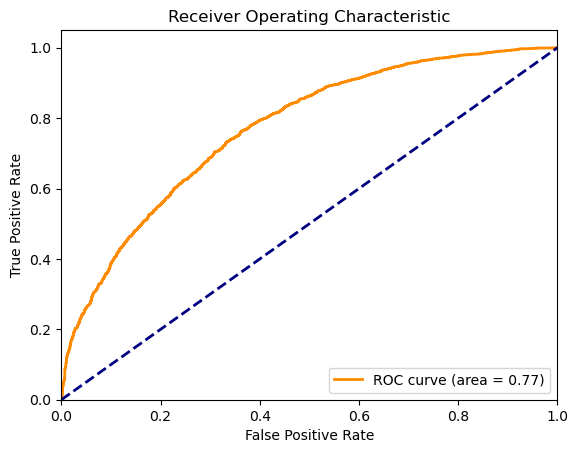

In [12]:
# Calculate ROC AUC
roc_auc = roc_auc_score(all_targets, all_probs)
print(f"ROC AUC: {roc_auc:.4f}")

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(all_targets, all_probs)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


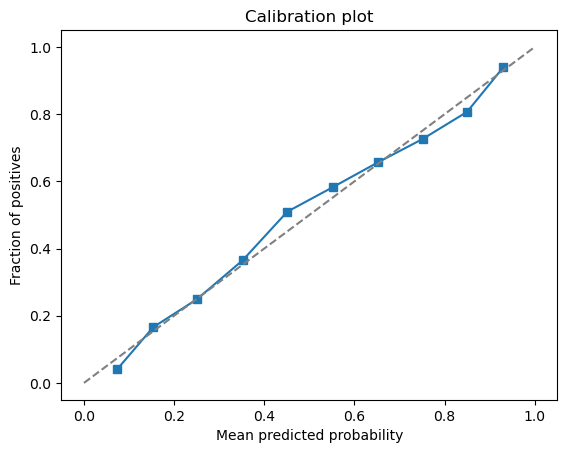

In [13]:
# Calculate calibration curve
fraction_of_positives, mean_predicted_value = calibration_curve(all_targets, all_probs, n_bins=10)

# Plot calibration plot
plt.figure()
plt.plot(mean_predicted_value, fraction_of_positives, 's-')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration plot')
plt.show()


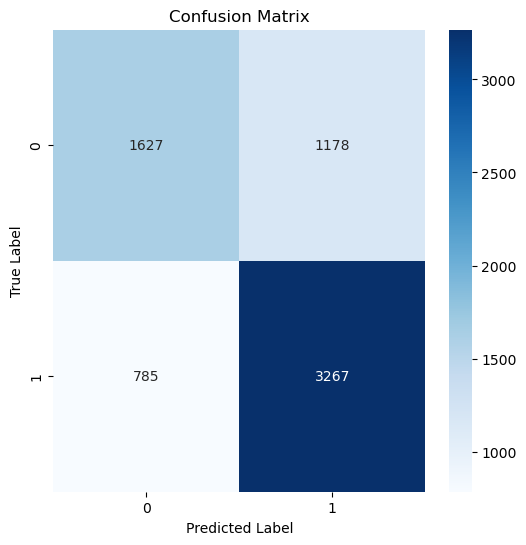

In [14]:
# Calculate the confusion matrix
cm = confusion_matrix(all_targets, all_preds)

# Plotting the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()